# Dog-Cat's Problem Submission

실제 학습된 모델과 TestSet을 이용하여 결과를 추출하여 Submit를 해본다.

## Load Test Data

Test 데이터를 00001.jpg 이런 형태로 미리 가공하였다.

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# 2. Get the file
downloaded = drive.CreateFile({'id':'1-pGQvj3veZlTm7gUGr77DFSvG0pSByeK'}) # replace the id with id of file you want to access
downloaded.GetContentFile('test_.zip')

In [0]:
!mkdir checkpoint

In [0]:
downloaded = drive.CreateFile({'id':'1CPIGvkDNcRRY-wzL2eNck-SKqFUKgzXs'}) # replace the id with id of file you want to access
downloaded.GetContentFile('./checkpoint/ckpt.t7')

## Zip File Extraction

In [0]:
import zipfile
import os, os.path

In [0]:
DataPath = './data'

In [0]:
objZip = zipfile.ZipFile('./test_.zip')
objZip.extractall(DataPath)

In [0]:
from IPython.display import Image

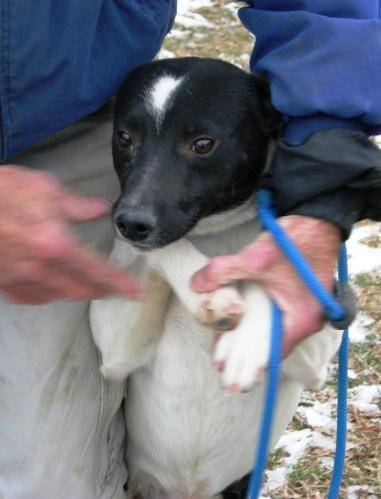

In [9]:
Image('./data/00001.jpg')

In [10]:
print("[TestData] TestData : [%d]" % len(os.listdir('./data/') ) )

[TestData] TestData : [12500]


Input Data Load SuccessFully!

## Pytorch Install

In [11]:
# torch 0.4 install for torch.no_grad()
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

# !pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
# !pip3 install torchvision

0.4.0
True


## Data Transform using PILOW

기존 dataLoader 객체를 사용하지 않고, Pilow를 이용하여 데이터를 기존의 방법과 같이 변환한다.

In [12]:
# 기존의 변환 방법

'''
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48833174, 0.4550874,  0.41697174), (0.2562639,  0.24982646, 0.25225964)),
])
'''

'\ntransform_train = transforms.Compose([\n    transforms.Resize((224,224)),\n    transforms.ToTensor(),\n    transforms.Normalize((0.48833174, 0.4550874,  0.41697174), (0.2562639,  0.24982646, 0.25225964)),\n])\n'

우선 tranforms.Compose를 분석한다.
https://pytorch.org/docs/master/torchvision/transforms.html

### Load Image Data

vision/folder를 분석하여 이미지를 로딩해본다.
https://github.com/pytorch/vision/blob/master/torchvision/datasets/folder.py

In [0]:
from PIL import Image

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

In [0]:
image = default_loader('./data/00001.jpg')

In [15]:
type(image)

PIL.Image.Image

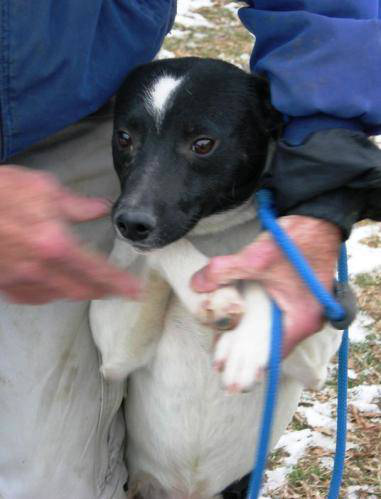

In [16]:
image

### Resize Image

입력된 이미지를 Resize 한다.

https://github.com/pytorch/vision/blob/master/torchvision/transforms/transforms.py

https://pytorch.org/docs/master/torchvision/transforms.html

In [0]:
import collections

try:
    import accimage
except ImportError:
    accimage = None

def _is_pil_image(img):
    if accimage is not None:
        return isinstance(img, (Image.Image, accimage.Image))
    else:
        return isinstance(img, Image.Image)

def resize(img, size, interpolation=Image.BILINEAR):
    r"""Resize the input PIL Image to the given size.
    Args:
        img (PIL Image): Image to be resized.
        size (sequence or int): Desired output size. If size is a sequence like
            (h, w), the output size will be matched to this. If size is an int,
            the smaller edge of the image will be matched to this number maintaing
            the aspect ratio. i.e, if height > width, then image will be rescaled to
            :math:`\left(\text{size} \times \frac{\text{height}}{\text{width}}, \text{size}\right)`
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    Returns:
        PIL Image: Resized image.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))
    if not (isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)):
        raise TypeError('Got inappropriate size arg: {}'.format(size))

    if isinstance(size, int):
        w, h = img.size
        if (w <= h and w == size) or (h <= w and h == size):
            return img
        if w < h:
            ow = size
            oh = int(size * h / w)
            return img.resize((ow, oh), interpolation)
        else:
            oh = size
            ow = int(size * w / h)
            return img.resize((ow, oh), interpolation)
    else:
        return img.resize(size[::-1], interpolation)

In [0]:
resize_image = resize(image, (224,224))

In [19]:
type(resize_image)

PIL.Image.Image

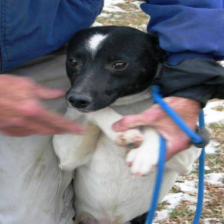

In [20]:
resize_image

## Convert Pytorch Tensor

resize 이미지를 Pytorch Tensor 형태로 바꾼다.

https://github.com/pytorch/vision/blob/master/torchvision/transforms/transforms.py

https://pytorch.org/docs/master/torchvision/transforms.html

In [0]:
import numpy as np
import torch

def _is_pil_image(img):
    if accimage is not None:
        return isinstance(img, (Image.Image, accimage.Image))
    else:
        return isinstance(img, Image.Image)


def _is_tensor_image(img):
    return torch.is_tensor(img) and img.ndimension() == 3


def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})

def to_tensor(pic):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    See ``ToTensor`` for more details.
    Args:
        pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
    Returns:
        Tensor: Converted image.
    """
    if not(_is_pil_image(pic) or _is_numpy_image(pic)):
        raise TypeError('pic should be PIL Image or ndarray. Got {}'.format(type(pic)))

    if isinstance(pic, np.ndarray):
        # handle numpy array
        img = torch.from_numpy(pic.transpose((2, 0, 1)))
        # backward compatibility
        if isinstance(img, torch.ByteTensor):
            return img.float().div(255)
        else:
            return img

    if accimage is not None and isinstance(pic, accimage.Image):
        nppic = np.zeros([pic.channels, pic.height, pic.width], dtype=np.float32)
        pic.copyto(nppic)
        return torch.from_numpy(nppic)

    # handle PIL Image
    if pic.mode == 'I':
        img = torch.from_numpy(np.array(pic, np.int32, copy=False))
    elif pic.mode == 'I;16':
        img = torch.from_numpy(np.array(pic, np.int16, copy=False))
    elif pic.mode == 'F':
        img = torch.from_numpy(np.array(pic, np.float32, copy=False))
    elif pic.mode == '1':
        img = 255 * torch.from_numpy(np.array(pic, np.uint8, copy=False))
    else:
        img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
    # PIL image mode: L, P, I, F, RGB, YCbCr, RGBA, CMYK
    if pic.mode == 'YCbCr':
        nchannel = 3
    elif pic.mode == 'I;16':
        nchannel = 1
    else:
        nchannel = len(pic.mode)
    img = img.view(pic.size[1], pic.size[0], nchannel)
    # put it from HWC to CHW format
    # yikes, this transpose takes 80% of the loading time/CPU
    img = img.transpose(0, 1).transpose(0, 2).contiguous()
    if isinstance(img, torch.ByteTensor):
        return img.float().div(255)
    else:
        return img

In [0]:
resize_image_tensor = to_tensor(resize_image)

In [23]:
type(resize_image_tensor)

torch.Tensor

In [24]:
resize_image_tensor.size()

torch.Size([3, 224, 224])

## Normalize Data

In [0]:
def normalize(tensor, mean, std):
    """Normalize a tensor image with mean and standard deviation.
    .. note::
        This transform acts in-place, i.e., it mutates the input tensor.
    See :class:`~torchvision.transforms.Normalize` for more details.
    Args:
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channely.
    Returns:
        Tensor: Normalized Tensor image.
    """
    if not _is_tensor_image(tensor):
        raise TypeError('tensor is not a torch image.')

    # This is faster than using broadcasting, don't change without benchmarking
    for t, m, s in zip(tensor, mean, std):
        t.sub_(m).div_(s)
    return tensor

In [0]:
resize_image_tensor_normal = normalize(resize_image_tensor, (0.48833174, 0.4550874,  0.41697174), (0.2562639,  0.24982646, 0.25225964) )

## Model Construction

In [0]:
import torch
import torchvision
import torchvision.models as models

In [0]:
# net = models.resnet50(num_classes=2)
net = models.resnet18(num_classes=2)
# net = models.vgg.vgg19_bn()
# net.children

In [0]:
import torch.nn as nn

In [30]:
from torch.autograd import Variable

net = net.cuda()
x = Variable(torch.randn(2,3,224,224))
x = x.to('cuda')
y = net(x)
print(y)

tensor([[ 0.0447, -0.3333],
        [ 0.0880, -0.1449]], device='cuda:0')


## Load Trained Model

In [31]:
import os, os.path

#@title Resume 여부
resume = True #@param {type:"boolean"}
if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.t7')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
    print('==> best_acc : ', best_acc)
    print('==> Done..')
else:
    start_epoch = 0
    best_acc = 0

==> Resuming from checkpoint..
==> best_acc :  tensor(94.3800, device='cuda:0')
==> Done..


In [32]:
x = Variable(torch.randn(2,3,224,224))
x = x.to('cuda')
type(x)
x.size()

torch.Size([2, 3, 224, 224])

In [33]:
y = net(x)
print(y)

tensor([[-8.8394,  9.0417],
        [ 3.3075, -3.0060]], device='cuda:0')


## Load Test Data by Pandas

In [0]:
import pandas as pd

In [0]:
test_list = os.listdir(DataPath)

In [36]:
print(test_list)

['11562.jpg', '06880.jpg', '07627.jpg', '05151.jpg', '04068.jpg', '06868.jpg', '06851.jpg', '08579.jpg', '04299.jpg', '06976.jpg', '07799.jpg', '08495.jpg', '06609.jpg', '05091.jpg', '06169.jpg', '05437.jpg', '06879.jpg', '05955.jpg', '06148.jpg', '07689.jpg', '03734.jpg', '03328.jpg', '10049.jpg', '02378.jpg', '03779.jpg', '03766.jpg', '01883.jpg', '12439.jpg', '07166.jpg', '05819.jpg', '10576.jpg', '10176.jpg', '11292.jpg', '03069.jpg', '00123.jpg', '06681.jpg', '09650.jpg', '04754.jpg', '07082.jpg', '02158.jpg', '09804.jpg', '05943.jpg', '07283.jpg', '04126.jpg', '10366.jpg', '06237.jpg', '06559.jpg', '03178.jpg', '01945.jpg', '06706.jpg', '12482.jpg', '02009.jpg', '00498.jpg', '03080.jpg', '11212.jpg', '11839.jpg', '02060.jpg', '06349.jpg', '01276.jpg', '11857.jpg', '09010.jpg', '10149.jpg', '07070.jpg', '06622.jpg', '08842.jpg', '06055.jpg', '05768.jpg', '02988.jpg', '04261.jpg', '06102.jpg', '00907.jpg', '06210.jpg', '09397.jpg', '08514.jpg', '02081.jpg', '12023.jpg', '07794.jpg'

In [0]:
test_list.sort()

In [38]:
print(test_list)

['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg', '00011.jpg', '00012.jpg', '00013.jpg', '00014.jpg', '00015.jpg', '00016.jpg', '00017.jpg', '00018.jpg', '00019.jpg', '00020.jpg', '00021.jpg', '00022.jpg', '00023.jpg', '00024.jpg', '00025.jpg', '00026.jpg', '00027.jpg', '00028.jpg', '00029.jpg', '00030.jpg', '00031.jpg', '00032.jpg', '00033.jpg', '00034.jpg', '00035.jpg', '00036.jpg', '00037.jpg', '00038.jpg', '00039.jpg', '00040.jpg', '00041.jpg', '00042.jpg', '00043.jpg', '00044.jpg', '00045.jpg', '00046.jpg', '00047.jpg', '00048.jpg', '00049.jpg', '00050.jpg', '00051.jpg', '00052.jpg', '00053.jpg', '00054.jpg', '00055.jpg', '00056.jpg', '00057.jpg', '00058.jpg', '00059.jpg', '00060.jpg', '00061.jpg', '00062.jpg', '00063.jpg', '00064.jpg', '00065.jpg', '00066.jpg', '00067.jpg', '00068.jpg', '00069.jpg', '00070.jpg', '00071.jpg', '00072.jpg', '00073.jpg', '00074.jpg', '00075.jpg', '00076.jpg', '00077.jpg'

In [0]:
test_data = pd.DataFrame(data=test_list, columns = ['filename'])

In [40]:
test_data.head()

,filename
0,00001.jpg
1,00002.jpg
2,00003.jpg
3,00004.jpg
4,00005.jpg


In [41]:
test_data.tail()

,filename
12495,12496.jpg
12496,12497.jpg
12497,12498.jpg
12498,12499.jpg
12499,12500.jpg


In [42]:
cost_list = np.zeros( (12500, ) )
print(cost_list)
test_data['cost'] = cost_list

[0. 0. 0. ... 0. 0. 0.]


In [43]:
test_data.head()

,filename,cost
0,00001.jpg,0.0
1,00002.jpg,0.0
2,00003.jpg,0.0
3,00004.jpg,0.0
4,00005.jpg,0.0


## Test One Data  

In [44]:
# Load & Resize data './data/00001.jpg'
first_data = resize_image_tensor_normal.to('cuda')
first_data = first_data.view(-1, 3, 224, 224)
type(first_data)
first_data.size()

torch.Size([1, 3, 224, 224])

In [45]:
y = net(first_data)
print(y)

tensor([[-5.9095,  6.1609]], device='cuda:0')


In [46]:
import torch.nn.functional as F
result = F.softmax(y, dim=1)
print(result)

tensor([[ 5.7261e-06,  9.9999e-01]], device='cuda:0')


In [47]:
print(result[0, 1].cpu().detach().numpy())

0.9999943


## Iterate All Data

In [48]:
cost_list = np.zeros( (12500, ) )

for index, row in test_data.iterrows():
  filename = DataPath + '/'+row['filename']
  image = default_loader(filename)
  resize_image = resize(image, (224,224))
  resize_image_tensor = to_tensor(resize_image)
  resize_image_tensor_normal = normalize(resize_image_tensor, (0.48833174, 0.4550874,  0.41697174), (0.2562639,  0.24982646, 0.25225964) )
  resize_image_cuda = resize_image_tensor_normal.to('cuda')
  inputData = resize_image_cuda.view(-1, 3, 224, 224)
  y = net(inputData)
  result = F.softmax(y, dim=1)
  cost_list[index] = result[0, 1].cpu().detach().numpy()
  # print(cost_list[index])
  if index%100 == 0:
    print(index)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400


In [0]:
test_data['cost'] = cost_list

In [50]:
test_data.head()

,filename,cost
0,00001.jpg,9.999943e-01
1,00002.jpg,9.999976e-01
2,00003.jpg,9.999998e-01
3,00004.jpg,9.999996e-01
4,00005.jpg,4.419112e-08


In [51]:
test_data.tail()

,filename,cost
12495,12496.jpg,2.257608e-12
12496,12497.jpg,1.681360e-09
12497,12498.jpg,1.000000e+00
12498,12499.jpg,1.000000e+00
12499,12500.jpg,1.165256e-04


In [0]:
test_data.to_csv('test_result.csv', index=False)

In [0]:
files.download('./test_result.csv')